(324, 12, 1) (140, 12, 1) (324, 1, 1) (140, 1, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 29378 (114.76 KB)
Trainable params: 29378 (114.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
5/5 [==============================] - 6s 196ms/step - loss: 754.0797 - val_loss: 366.3358
Ep

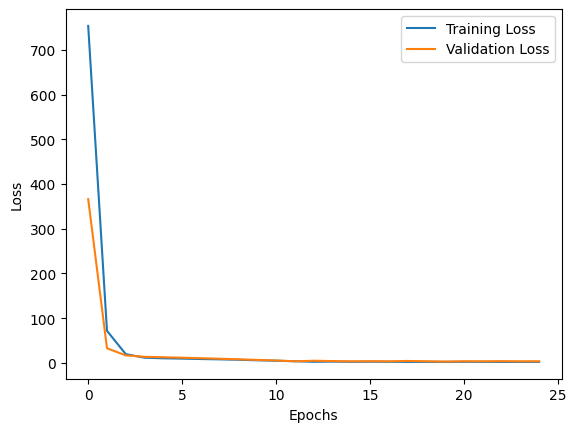

PICP: 0.95
MPIW: 59.356998443603516


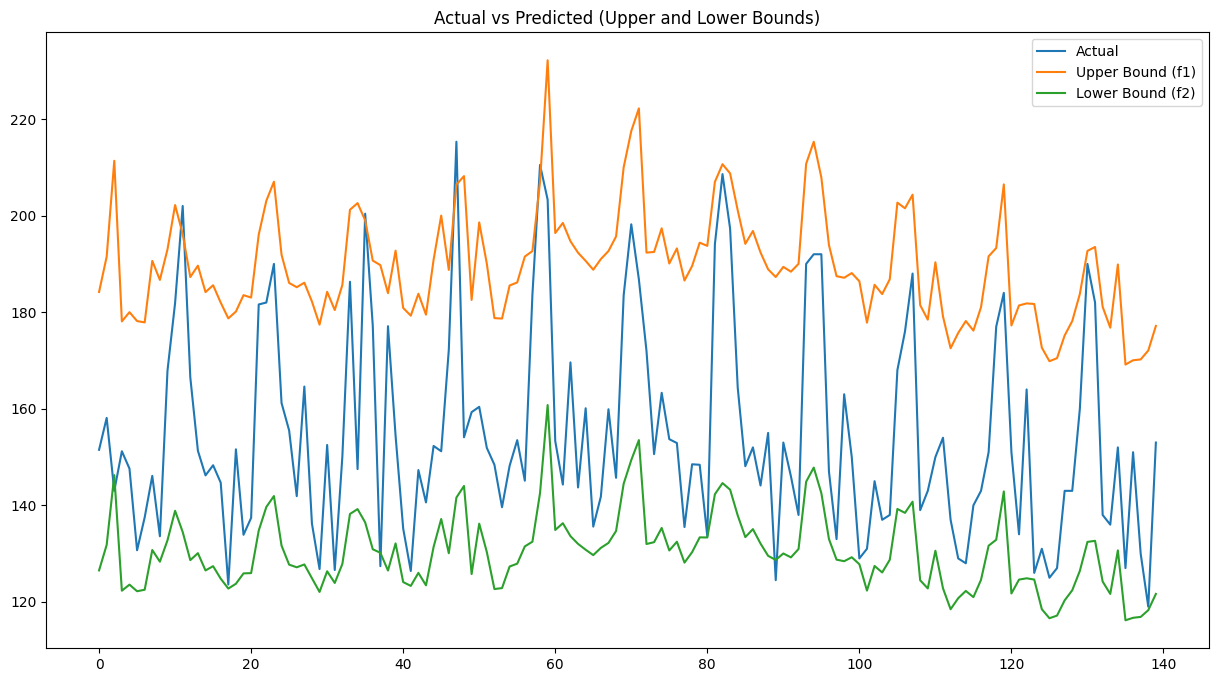

In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import keras.backend as K
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()


r = 0.5
q = 0.95
delta = 0.006
l = 2

def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f1 = y_pred[:, 0]
    f2 = y_pred[:, 1]

    c1 = (1 - q) * (y_true - f2)
    c2 = (1 - q) * (f1 - y_true)
    c3 = q * (f2 - y_true)
    c4 = q * (y_true - f1)

    loss = K.switch(tf.math.logical_and((y_true <= f1), (y_true >= f2)),
                    K.switch((y_true > r * (f1 + f2)), c1, c2),
                    K.switch((f2 > y_true), c3, c4)) + (delta * tf.math.abs(f1 - f2))

    return loss


dataset = pd.read_csv(r"C:\Users\aades\Downloads\LSTM_Experiment\LSTM_Experiment\Datasets\datasets_56102_107707_monthly-beer-production-in-austr.csv")

dataset["Month"] = pd.to_datetime(dataset["Month"])
dataset["Monthly beer production"] = dataset["Monthly beer production"].astype(float)

data = dataset["Monthly beer production"].to_numpy().reshape((len(dataset["Monthly beer production"]), 1))

mean_data = np.mean(data)
std_data = np.std(data)

def relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

if std_data == 0:
    data_normalized = data - mean_data  # Only mean-center if std is 0
else:
    data_normalized = (data - mean_data) / std_data  # Standardize normally

def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len + 1):
        in_.append(x[i:(i + train_len), feature_cols].tolist())
        out_.append(x[(i + train_len):(i + train_len + test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

X_in, X_out = truncate(data, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=12, test_len=1)

# Split the data into training and testing sets (70% training, 30% testing)
train_x = X_in[:math.floor(X_in.shape[0] * 0.70)]
train_y = X_out[:math.floor(X_out.shape[0] * 0.70)]
test_x = X_in[math.floor(X_in.shape[0] * 0.70):]
test_y = X_out[math.floor(X_out.shape[0] * 0.70):]
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

# Define LSTM model architecture
input_train = Input(shape=(12, 1))  # 100 time steps, 1 feature (production)
# initializer = tf.keras.initializers.GlorotNormal(seed=64)  # Weight initialization
initializer = tf.keras.initializers.he_normal(seed=128)

# LSTM layers
lstm_l1 = LSTM(64, activation='relu', kernel_initializer=initializer, return_sequences=True)(input_train)
lstm_l2 = LSTM(32, activation='relu', kernel_initializer=initializer, return_sequences=False)(lstm_l1)

# Output layer predicting the upper and lower bounds
out = Dense(2)(lstm_l2)  # Output layer with 2 units (upper and lower bounds)
model = Model(inputs=input_train, outputs=out)

opt = Adam(learning_rate=0.01)
model.compile(loss=confidence_loss, optimizer=opt)
model.summary()


# Train the model
epochs = 300
start_time = datetime.datetime.now()
stop_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
history = model.fit(train_x, train_y, validation_split=0.1, epochs=epochs, verbose=1, batch_size=64,callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
print(f'Seconds taken: {round(total_time.total_seconds(), 1)}, Start time: {start_time.strftime("%H:%M:%S")}, End time: {end_time.strftime("%H:%M:%S")}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred = model.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y)  # Actual test values
y_u_pred = y_pred[:, 0]  # Upper bound predictions
y_l_pred = y_pred[:, 1]  # Lower bound predictions

K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_

print(f'PICP: {np.mean(K_u * K_l)}')
print(f'MPIW: {np.round(np.mean(y_u_pred - y_l_pred), 3)}')


actual = np.squeeze(test_y)
pred1 = y_u_pred
pred2 = y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx, actual, label='Actual')
plt.plot(numEx, pred1, label='Upper Bound (f1)')
plt.plot(numEx, pred2, label='Lower Bound (f2)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (Upper and Lower Bounds)')
plt.show()
#0.005,6,7,8